## Classificações de sons urbanos usando CNN e MLP

In [14]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from keras.callbacks import EarlyStopping
from keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D,MaxPooling1D,LeakyReLU,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
import soundata
import tensorflow as tf
import os
import librosa
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## Extração de features e download dos sons

In [15]:
dfclass = pd.read_csv(r'UrbanSound8K.csv')
dfclass.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [16]:
FOLDS_PATH = "../UrbanSound8K/audio/"
DURATION = 4
SAMPLE_RATE = 44100

In [17]:
def load_fold_data(features_file, labels_file, label_encoder):
    features = pd.read_csv(features_file).values
    labels = pd.read_csv(labels_file)['0']
    encoded_labels = label_encoder.transform(labels)
    return features, encoded_labels

In [18]:
def create_label_mapping(folds_path, n_folds):
    all_labels = set()
    for fold_number in range(1, n_folds + 1):
        labels_file = f'csv/labelsfold{fold_number}.csv'
        df_labels = pd.read_csv(labels_file)
        all_labels.update(df_labels['0'].unique())
    
    label_encoder = LabelEncoder()
    label_encoder.fit(list(all_labels))
    return label_encoder


## Duração dos áudios

In [19]:
def reformat_audio_data(audio_file_path):
    audio_data_res, _ = librosa.load(audio_file_path,sr=SAMPLE_RATE)

    audio_duration = librosa.get_duration(y=audio_data_res,sr=SAMPLE_RATE)
    if audio_duration < DURATION:
        audio_data_adj = np.pad(audio_data_res, (0, int((DURATION-audio_duration)*SAMPLE_RATE)), 'constant')
    else:
        audio_data_adj = audio_data_res
    return audio_data_adj

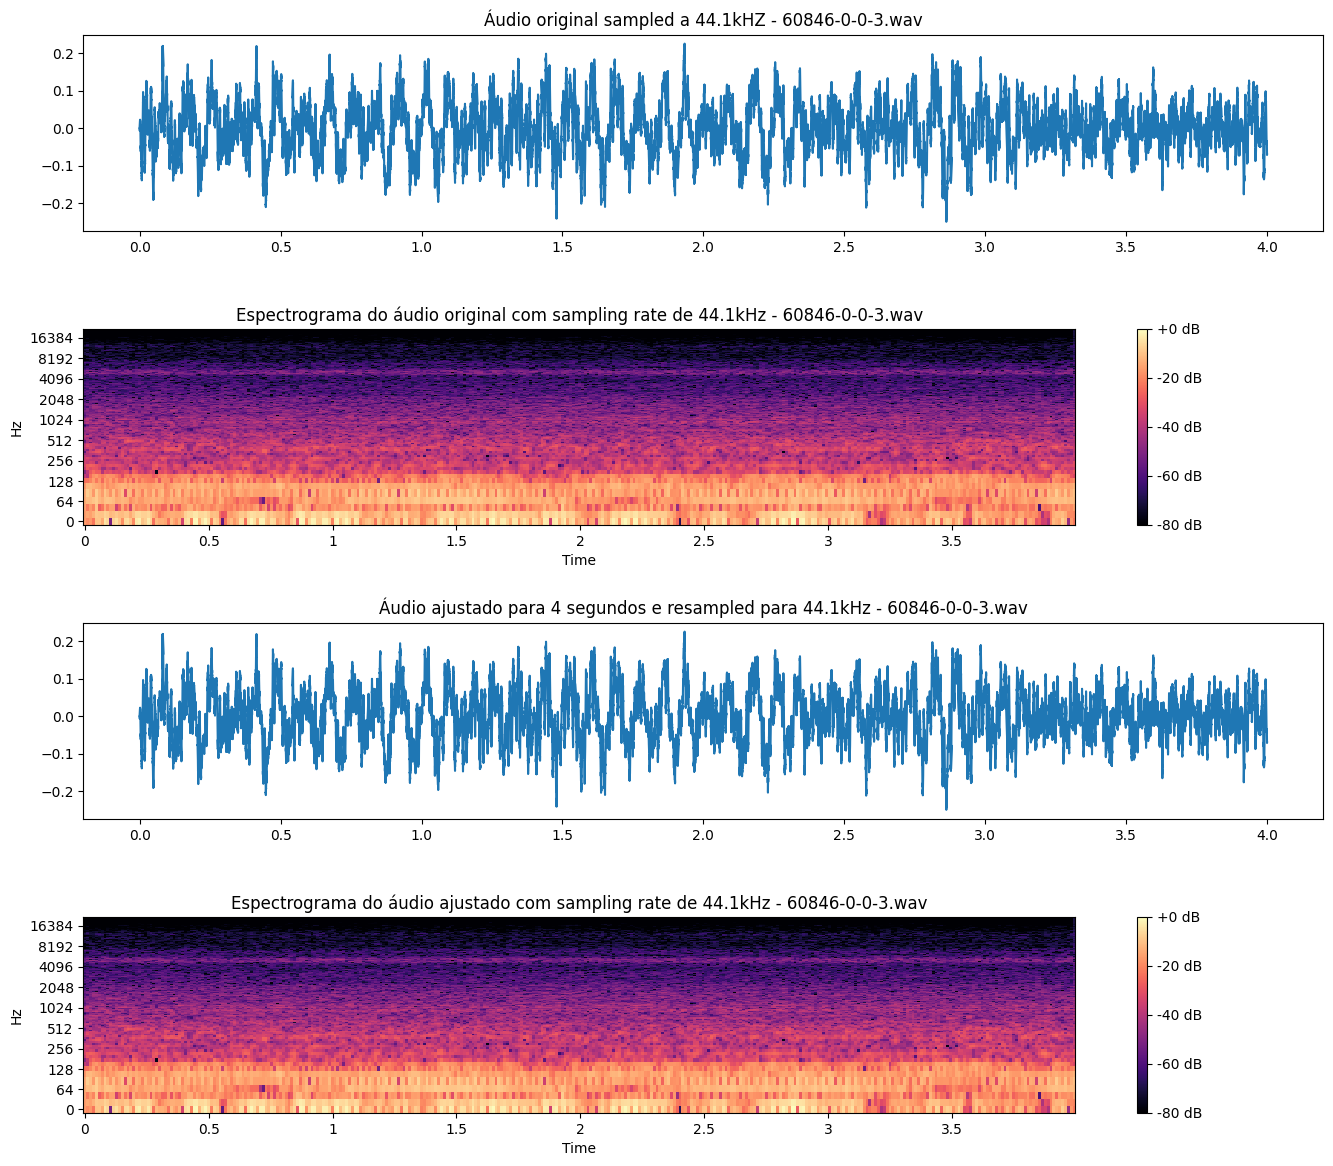

In [21]:
fold1_path = os.path.join(FOLDS_PATH, "fold5")
filenames = os.listdir(fold1_path)
index = 1

path = os.path.join(fold1_path,filenames[index])

audio_data_ori, sr = librosa.load(path,sr=None)
audio_data_adj = reformat_audio_data(path)
plt.figure(figsize=(16,14))
plt.subplot(4,1,1)
plt.plot(np.linspace(0, len(audio_data_ori) / sr, num=len(audio_data_ori)), audio_data_ori)
plt.title(f'Áudio original sampled a {sr/1000}kHZ - {filenames[index]}')

spectrogram = np.abs(librosa.stft(audio_data_ori))
plt.subplot(4,1,2)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.title(f'Espectrograma do áudio original com sampling rate de {sr/1000}kHz - {filenames[1]}')
plt.colorbar(format='%+2.0f dB')

plt.subplot(4,1,3)
plt.plot(np.linspace(0, len(audio_data_adj) / SAMPLE_RATE, num=len(audio_data_adj)), audio_data_adj)
plt.title(f'Áudio ajustado para 4 segundos e resampled para {SAMPLE_RATE/1000}kHz - {filenames[index]}')

spectrogram = np.abs(librosa.stft(audio_data_adj))
plt.subplot(4,1,4)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.title(f'Espectrograma do áudio ajustado com sampling rate de {SAMPLE_RATE/1000}kHz - {filenames[1]}')
plt.colorbar(format='%+2.0f dB')

plt.subplots_adjust(hspace=0.5)

### Quando os áudios são maiores que o limite são cortados, quando são menores, como neste exemplo, são completados com zeros.

In [156]:
def load_data(FOLDS_PATH):
    features = []
    labels = []
    
    folds = [fold for fold in os.listdir(FOLDS_PATH) if "fold" in fold]
    for fold in folds:
        audio_files = librosa.util.find_files(FOLDS_PATH+"/"+fold)
        features = []
        labels = []
        for audio_file_path in audio_files:

            # Carregar o arquivo de áudio
            audio_data, sample_rate = librosa.load(audio_file_path,sr=44100)
            audio_data = librosa.util.fix_length(audio_data, size=int(4 * 44100))
            # Extrair características (exemplo: MFCCs)

            mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
            mfccs_mean = np.mean(mfccs.T, axis=0)  # Média dos MFCCs ao longo do tempo
            mfccs_max = np.max(mfccs.T, axis=0)
            mfccs_min = np.min(mfccs.T, axis=0)
            mfccs_median = np.median(mfccs.T, axis=0)
            
            # Extração de Chroma
            chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
            chroma_mean = np.mean(chroma, axis=1)
            chroma_min = np.min(chroma, axis=1)
            chroma_median = np.median(chroma, axis=1)
            chroma_max = np.max(chroma, axis=1)

            # Extração de Spectral Contrast
            spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
            spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
            spectral_contrast_median = np.median(spectral_contrast, axis=1)
            spectral_contrast_min = np.min(spectral_contrast, axis=1)
            spectral_contrast_max = np.max(spectral_contrast, axis=1)

            # Extração de Zero Crossing Rate
            zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_data)
            zero_crossing_rate_mean = np.mean(zero_crossing_rate)
            zero_crossing_rate_median = np.median(zero_crossing_rate)
            zero_crossing_rate_max = np.max(zero_crossing_rate)
            zero_crossing_rate_min = np.min(zero_crossing_rate)

#             # Combinando todas as características
            combined_features = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, zero_crossing_rate_mean,mfccs_max,mfccs_min,mfccs_max,chroma_min,chroma_max,chroma_median,spectral_contrast_min,spectral_contrast_max,spectral_contrast_median,zero_crossing_rate_min,zero_crossing_rate_max,zero_crossing_rate_median))
            #combined_features=np.hstack((mfccs_mean,mfccs_max,mfccs_min,mfccs_median))
            # Adicionar características à lista
            features.append(combined_features)

            audio_file = audio_file_path.split("/")[-1]
            label=dfclass.loc[dfclass['slice_file_name'] == audio_file, 'class'].iloc[0]
            # Adicionar o rótulo à lista (modificar conforme necessário)
           
            labels.append(label)

        df = pd.DataFrame(features)
        df.to_csv(f"csv/features{fold}.csv")
        dl= pd.DataFrame(labels)
        dl.to_csv(f"csv/labels{fold}.csv")
        print(f"{fold} finished")           
 


load_data(FOLDS_PATH)

/home/guilherme/.local/lib/python3.8/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


fold1 finished
fold10 finished
fold2 finished
fold3 finished
fold4 finished
fold5 finished
fold6 finished
fold7 finished
fold8 finished
fold9 finished


## Dividimos as features e as labels por folds para depois podermos treinar com os folds predefinidos.

## Vamos observar cada fold em particular

['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


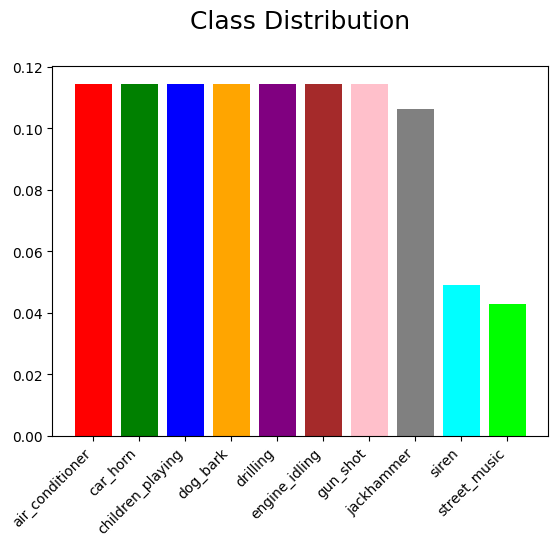

In [22]:
class_dict = dfclass['class'].value_counts(normalize=True)
classes = np.unique(dfclass['class'])
print(classes)
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'lime']
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.bar(classes,class_dict.values, color=colors)
plt.xticks(rotation=45, ha='right')
plt.show(block=False)

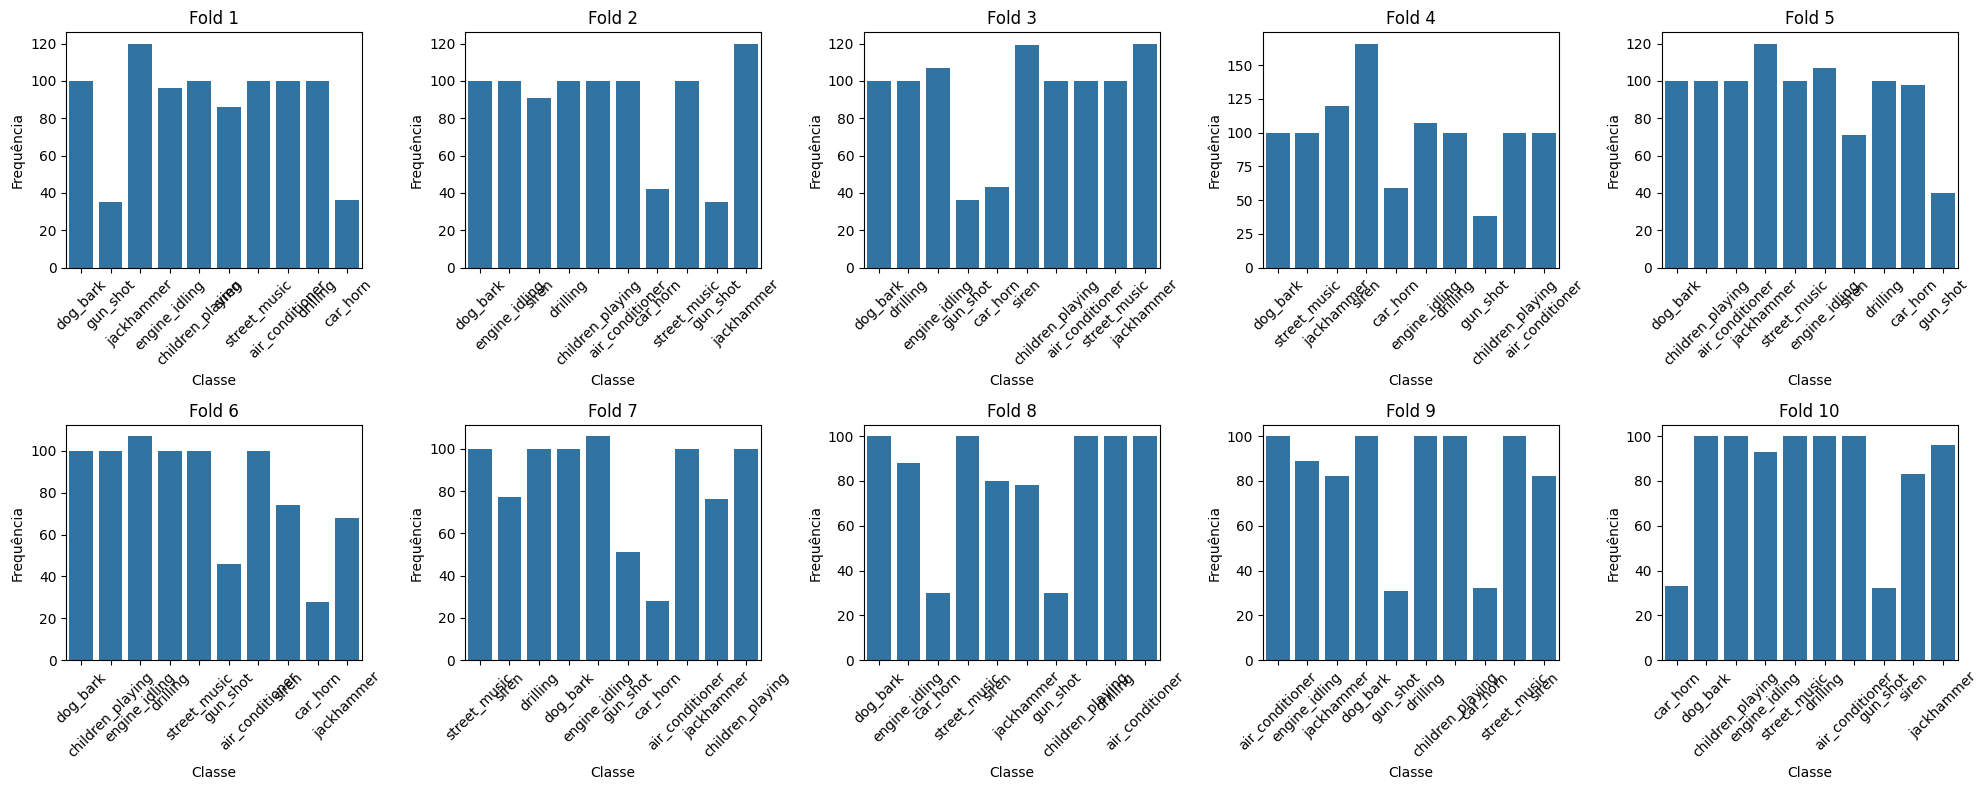

In [23]:
def plot_label_distribution_all_folds(n_folds):
    # Número de linhas e colunas para os subplots
    nrows = 2
    ncols = 5

    # Configurar o layout para os subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))  # Ajuste o tamanho conforme necessário

    for fold_number in range(1, n_folds + 1):
        # Carregar os rótulos do fold específico
        labels_path = f"csv/labelsfold{fold_number}.csv"
        df_labels = pd.read_csv(labels_path)

        # Determinar a posição do subplot
        row = (fold_number - 1) // ncols
        col = (fold_number - 1) % ncols

        # Plotar o gráfico no subplot correspondente
        sns.countplot(x=df_labels['0'], ax=axes[row, col])
        axes[row, col].set_title(f'Fold {fold_number}')
        axes[row, col].set_xlabel('Classe')
        axes[row, col].set_ylabel('Frequência')
        axes[row, col].tick_params(axis='x', rotation=45)

    # Ajustar o layout e exibir a figura
    plt.tight_layout()
    plt.show()

# Exemplo de uso para todos os 10 folds
plot_label_distribution_all_folds(10)

### Podemos observar que algumas folds estão um pouco desbalanceadas e por isso vamos definir uma métrica para aplicar SMOTE em alguns casos. 

# Modelos

## 10-Fold Cross Validation

### Para a CNN

In [24]:
def create_cnn_model(X_train_shape1):
    model = Sequential()

    model.add(Conv1D(16, 3, input_shape=(X_train_shape1,1), padding='same', activation='relu', 
                        kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))

    model.add(Conv1D(32, 3, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [25]:
model_cnn = create_cnn_model(241)
keras.utils.plot_model(model_cnn, 'multi_input_and_output_model.png', show_shapes=True)

NameError: name 'keras' is not defined

In [26]:
def kfold(n_folds,label_encoder):
    accuracies = []
    conf_matrices = []
    all_histories = []
    smotess=''
    scaler = StandardScaler()
    for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            features_file = f'csv/featuresfold{fold}.csv'
            labels_file = f'csv/labelsfold{fold}.csv'
            features, encoded_labels = load_fold_data(features_file, labels_file, label_encoder)

            if fold == test_fold:
                X_test, y_test = features, encoded_labels
            else:
                X_train.append(features)
                y_train.append(encoded_labels)

        # Concatenar e preparar os dados de treino
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        
        unique, counts = np.unique(y_train, return_counts=True)
        
        if min(counts) / max(counts) < 0.5 :  # Exemplo de critério, ajuste conforme necessário
            # Aplicar SMOTE
            smote = SMOTE()
            X_train, y_train = smote.fit_resample(X_train, y_train)
            smotess='com SMOTE'

            
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train)
        y_test_categorical = to_categorical(y_test)
        
        model = create_cnn_model(X_train.shape[1])



        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        hist = model.fit(X_train, y_train_categorical, epochs=75, batch_size=64, validation_data=(X_test, y_test_categorical), callbacks=[early_stopping],verbose=0)

        # Construir, compilar e treinar o modelo
        all_histories.append(hist.history)
        # Avaliação do modelo
        test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)
        
        accuracies.append(test_accuracy)
        print(f"Fold {test_fold} completa {smotess}")
    
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    mean_conf_matrix = np.mean(conf_matrices, axis=0)

    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy,model


### Para o MLP

In [27]:
def create_mlp_model(X_train_shape1):
    modelMLP = Sequential()
    modelMLP.add(Dense(128, activation='relu', input_shape=(X_train_shape1,),
                    kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    modelMLP.add(Dropout(0.3))
    modelMLP.add(Dense(128, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    modelMLP.add(Dense(10, activation='softmax'))

    return modelMLP

In [ ]:
model_mlp = create_mlp_model(241)
keras.utils.plot_model(model_mlp, 'multi_input_and_output_model.png', show_shapes=True)

In [28]:
def kfoldmlp(n_folds, label_encoder, num_classes):
    accuracies = []
    conf_matrices = []
    all_histories = []
    scaler = StandardScaler()
    smotess=''

    for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            features_file = f'csv/featuresfold{fold}.csv'
            labels_file = f'csv/labelsfold{fold}.csv'
            features, encoded_labels = load_fold_data(features_file, labels_file, label_encoder)

            if fold == test_fold:
                X_test, y_test = features, encoded_labels
            else:
                X_train.append(features)
                y_train.append(encoded_labels)

        # Concatenar e preparar os dados de treino
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        unique, counts = np.unique(y_train, return_counts=True)
        somtess='sem SMOTE'

        if min(counts) / max(counts) < 0.5 :  # Exemplo de critério, ajuste conforme necessário
            # Aplicar SMOTE
            smote = SMOTE()
            X_train, y_train = smote.fit_resample(X_train, y_train)
            smotess='com SMOTE'
        
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))

        # Normalizar os dados
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train, num_classes=num_classes)
        y_test_categorical = to_categorical(y_test, num_classes=num_classes)

        modelMLP = create_mlp_model(X_train.shape[1])

        
        modelMLP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        # Construir, compilar e treinar o modelo
        hist = modelMLP.fit(X_train, y_train_categorical, epochs=100, batch_size=64, validation_data=(X_test, y_test_categorical), callbacks=[early_stopping], verbose=0)
        all_histories.append(hist.history)

        # Avaliação do modelo
        test_loss, test_accuracy = modelMLP.evaluate(X_test, y_test_categorical)
        y_pred = modelMLP.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)
        accuracies.append(test_accuracy)
        print(f"Fold {test_fold} completa {smotess}")

    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy


## Primeiro Modelo Convulsional Neural Network

In [29]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)

all_histories, mean_conf_matrix, mean_accuracy, std_accuracy,model=kfold(10,label_encoder)

28/28 [==============================] - 0s 4ms/step
Fold 1 completa com SMOTE


KeyboardInterrupt: 

Acurácia média: 0.62, Desvio padrão: 0.04


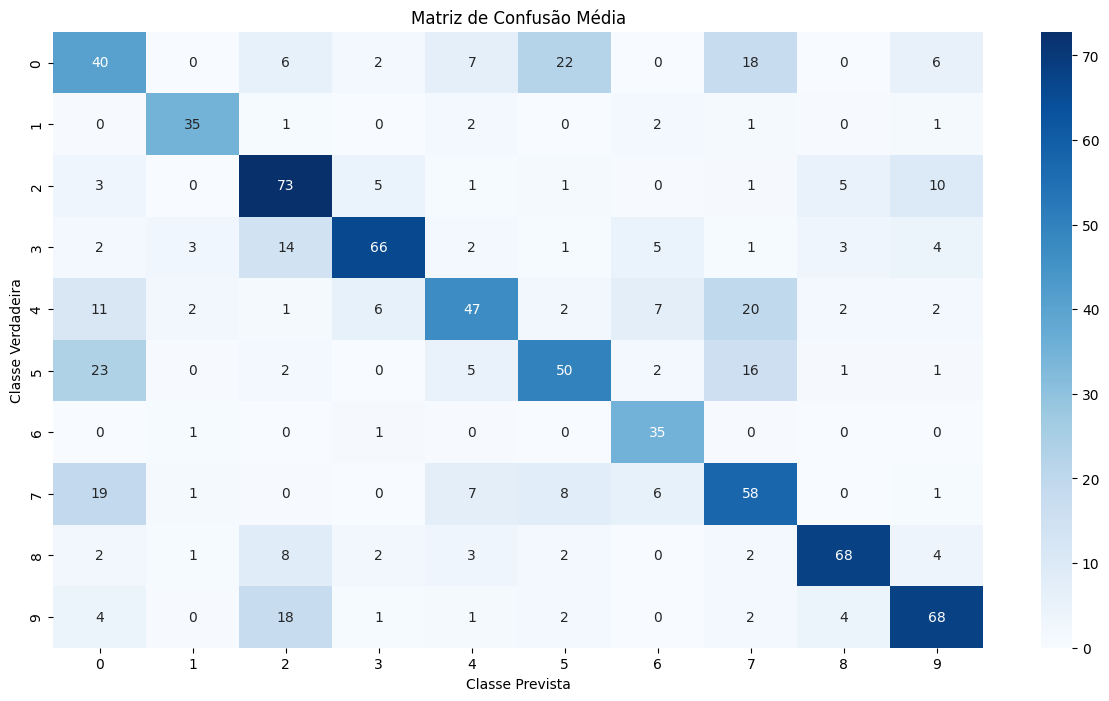

In [88]:
print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")

# Criar o mapa de calor usando Seaborn
plt.figure(figsize=(15, 8))  # Ajuste o tamanho conforme necessário
sns.heatmap(mean_conf_matrix, annot=True, fmt=".0f", cmap='Blues', cbar=True)
# Adicionar títulos e rótulos
plt.title('Matriz de Confusão Média')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')

# Mostrar o gráfico
plt.show()

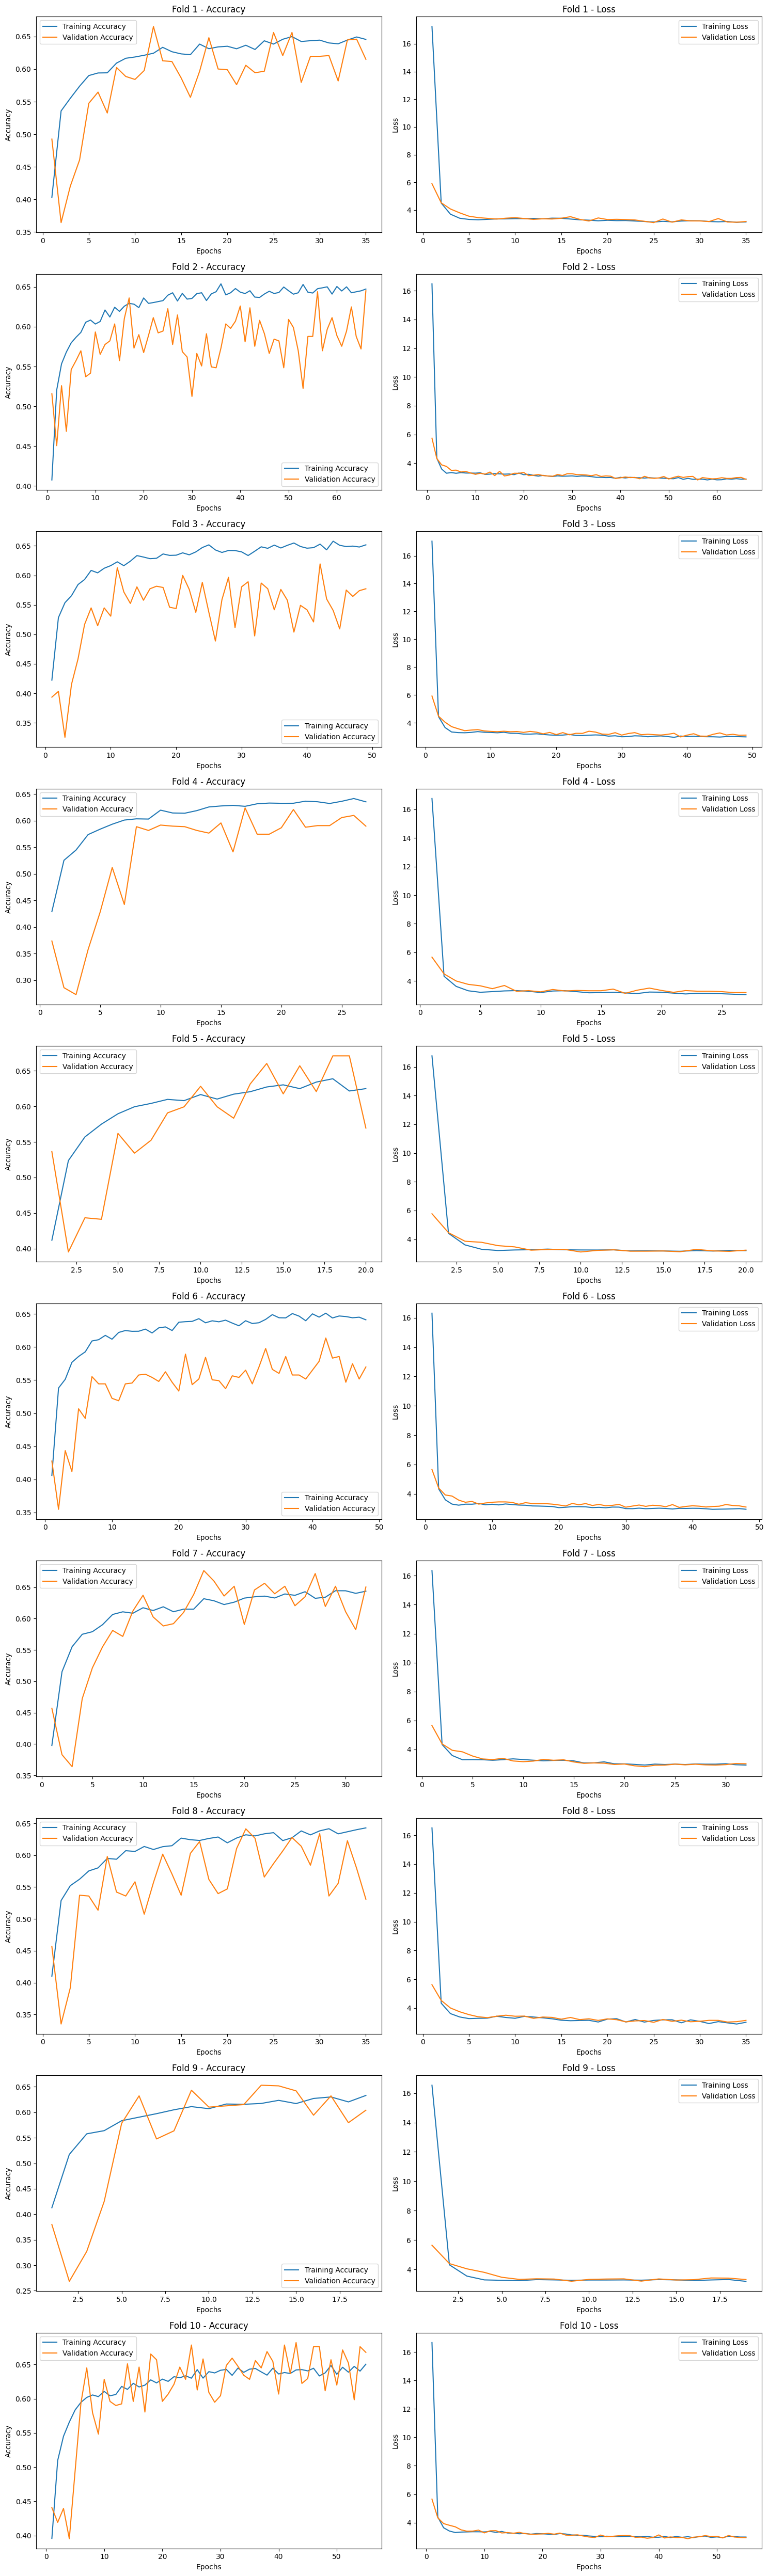

In [89]:
import matplotlib.pyplot as plt

def plot_all_histories(all_histories):
    # Define o número de linhas e colunas para a grade de subplots
    n_rows = 10  # Uma linha para cada fold
    n_cols = 2   # Duas colunas: uma para acurácia e outra para perda

    # Cria uma figura grande para acomodar todos os subplots
    plt.figure(figsize=(15, 50))  # Ajuste o tamanho conforme necessário

    for i, history in enumerate(all_histories):
        epochs = range(1, len(history['categorical_accuracy']) + 1)

        # Subplot para acurácia
        plt.subplot(n_rows, n_cols, 2*i + 1)
        plt.plot(epochs, history['categorical_accuracy'], label='Training Accuracy')
        plt.plot(epochs, history['val_categorical_accuracy'], label='Validation Accuracy')
        plt.title(f'Fold {i+1} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Subplot para perda
        plt.subplot(n_rows, n_cols, 2*i + 2)
        plt.plot(epochs, history['loss'], label='Training Loss')
        plt.plot(epochs, history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {i+1} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Chamar a função para plotar todos os históricos
plot_all_histories(all_histories)


## Multi-Layer Perceptron

In [94]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)
all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfoldmlp(n_folds, label_encoder, 10)

28/28 [==============================] - 0s 736us/step
Fold 1 completa com SMOTE
28/28 [==============================] - 0s 733us/step
Fold 2 completa com SMOTE
29/29 [==============================] - 0s 683us/step
Fold 3 completa com SMOTE
31/31 [==============================] - 0s 654us/step
Fold 4 completa com SMOTE
30/30 [==============================] - 0s 643us/step
Fold 5 completa com SMOTE
26/26 [==============================] - 0s 675us/step
Fold 6 completa com SMOTE
27/27 [==============================] - 0s 670us/step
Fold 7 completa com SMOTE
26/26 [==============================] - 0s 670us/step
Fold 8 completa com SMOTE
26/26 [==============================] - 0s 819us/step
Fold 9 completa com SMOTE
27/27 [==============================] - 0s 681us/step
Fold 10 completa com SMOTE


Acurácia média: 0.61, Desvio padrão: 0.04


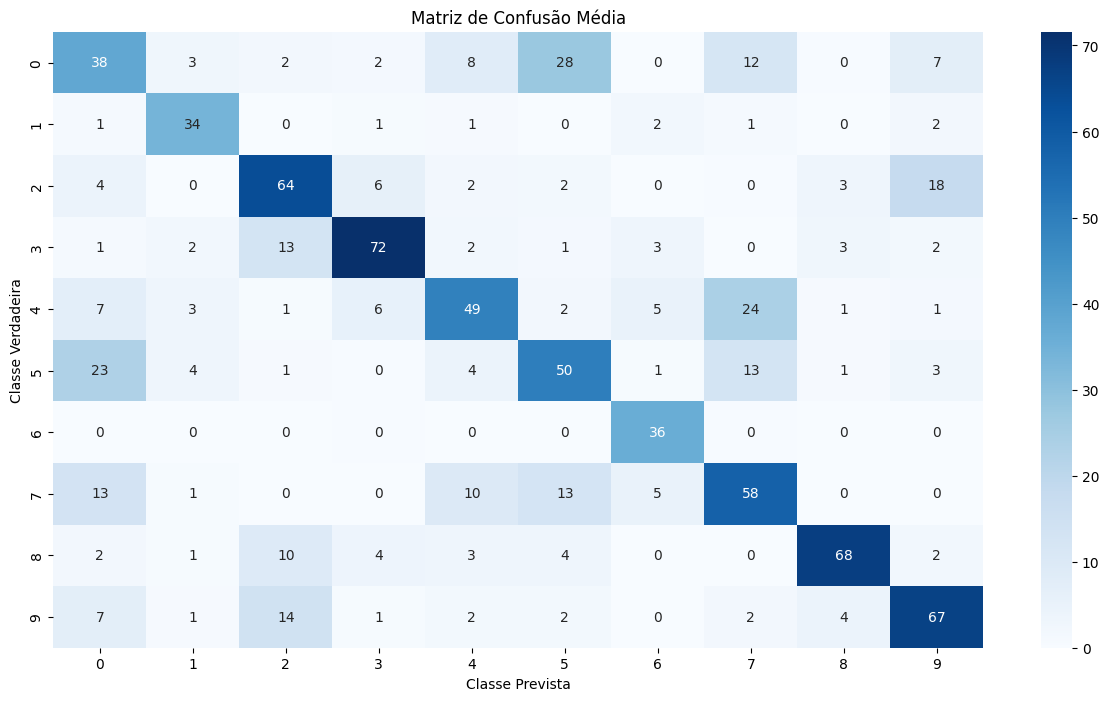

In [95]:
print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")

# Criar o mapa de calor usando Seaborn
plt.figure(figsize=(15, 8))  # Ajuste o tamanho conforme necessário
sns.heatmap(mean_conf_matrix, annot=True, fmt=".0f", cmap='Blues', cbar=True)
# Adicionar títulos e rótulos
plt.title('Matriz de Confusão Média')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')

# Mostrar o gráfico
plt.show()

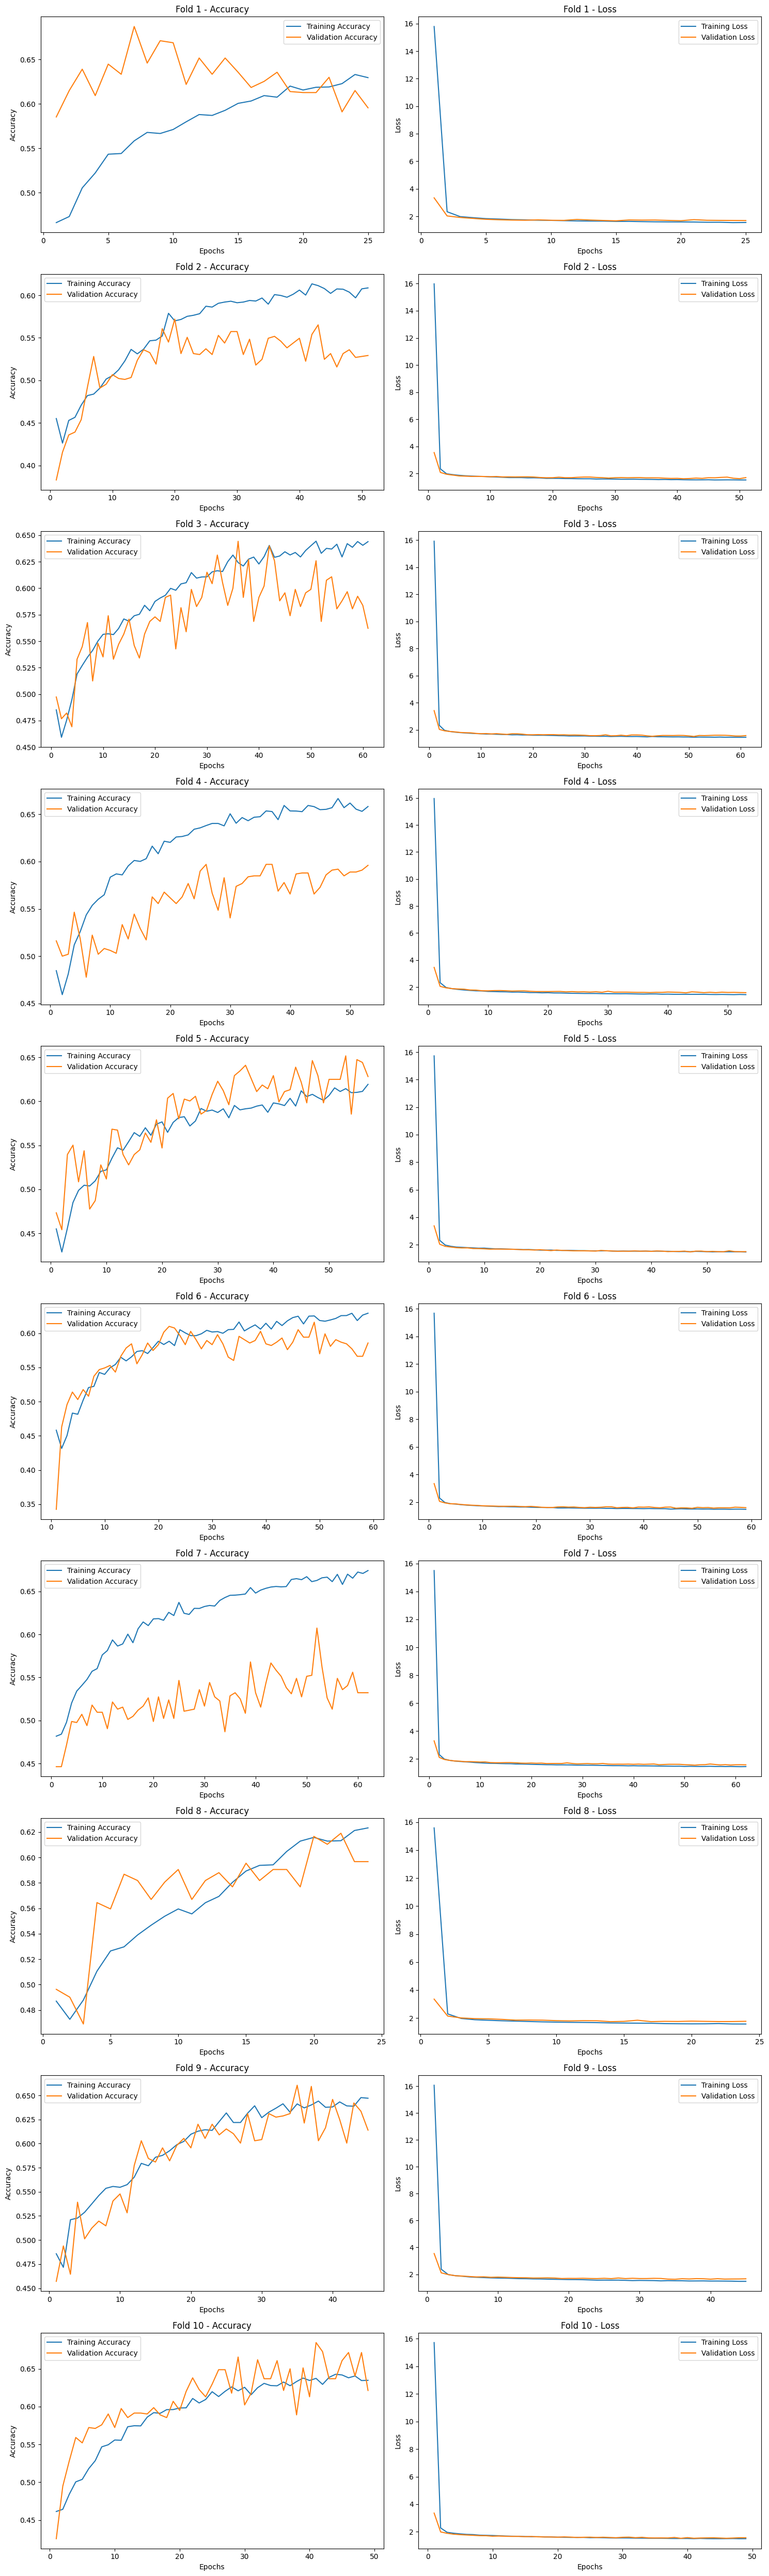

In [96]:
import matplotlib.pyplot as plt

def plot_all_histories(all_histories):
    # Define o número de linhas e colunas para a grade de subplots
    n_rows = 10  # Uma linha para cada fold
    n_cols = 2   # Duas colunas: uma para acurácia e outra para perda

    # Cria uma figura grande para acomodar todos os subplots
    plt.figure(figsize=(15, 50))  # Ajuste o tamanho conforme necessário

    for i, history in enumerate(all_histories):
        epochs = range(1, len(history['categorical_accuracy']) + 1)

        # Subplot para acurácia
        plt.subplot(n_rows, n_cols, 2*i + 1)
        plt.plot(epochs, history['categorical_accuracy'], label='Training Accuracy')
        plt.plot(epochs, history['val_categorical_accuracy'], label='Validation Accuracy')
        plt.title(f'Fold {i+1} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Subplot para perda
        plt.subplot(n_rows, n_cols, 2*i + 2)
        plt.plot(epochs, history['loss'], label='Training Loss')
        plt.plot(epochs, history['val_loss'], label='Validation Loss')
        plt.title(f'Fold {i+1} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Chamar a função para plotar todos os históricos
plot_all_histories(all_histories)
